Initializing analysis...

🔍 Loading country data...
❌ Error loading benin data: No data file found for benin
❌ Error loading sierra_leone data: No data file found for sierra_leone
✅ Data loaded successfully

📊 Generating visual comparisons...


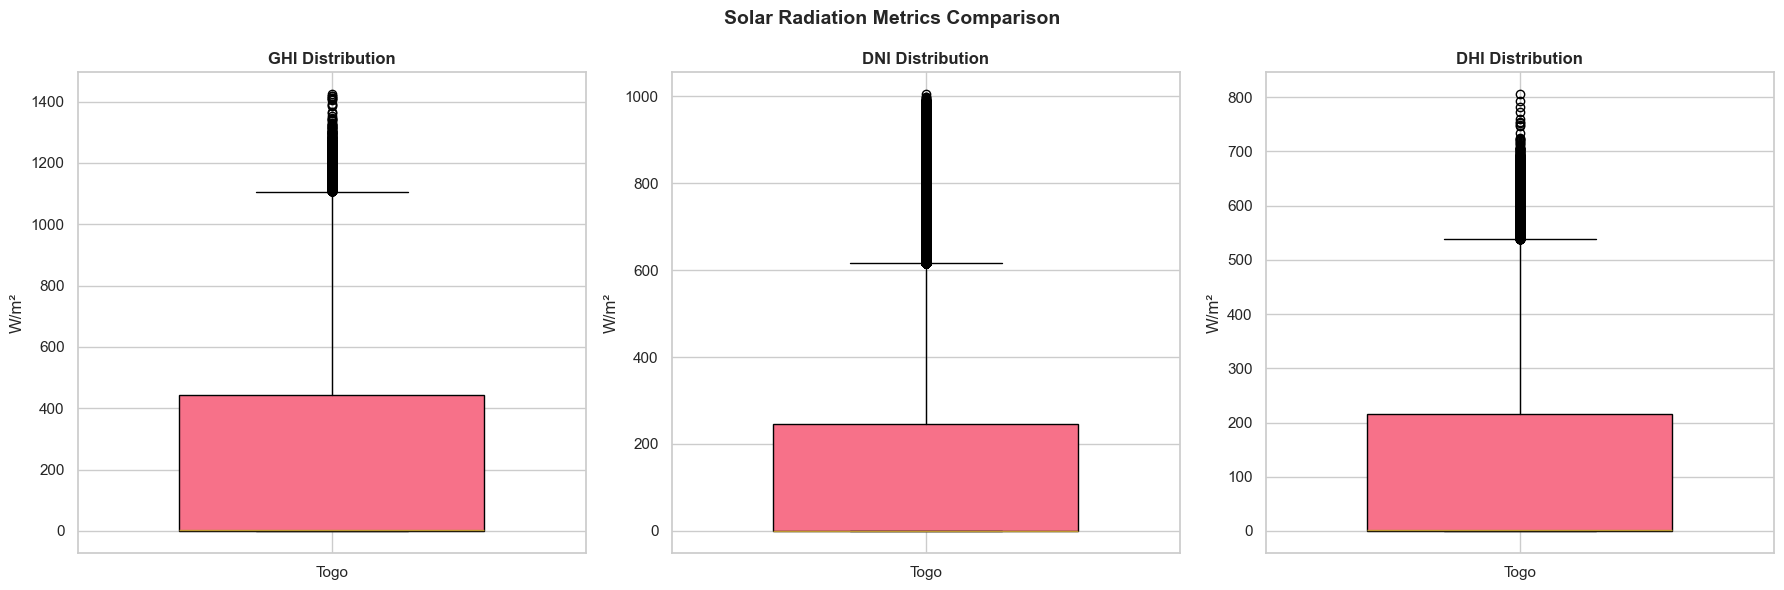


📈 Statistical Analysis:

📋 Summary Statistics:


,Country,Mean GHI,Median GHI,Std GHI,Max GHI
0,Togo,231.720000,2.100000,321.690000,1424.000000



🏆 Country Ranking:


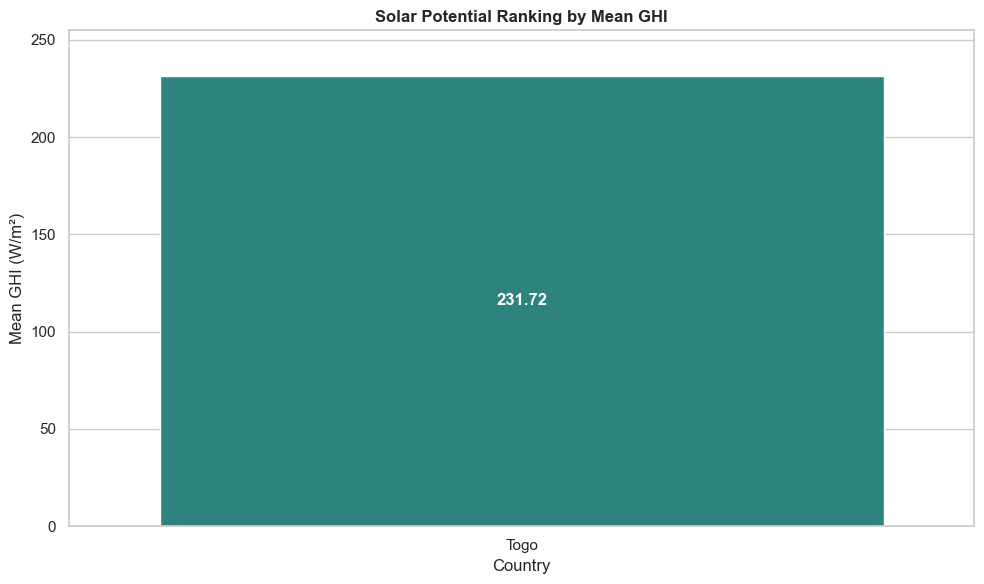


🌟 Recommendation: Togo has the highest solar potential

✅ Analysis completed successfully


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import os
from pathlib import Path

# ======================
# 1. CONFIGURATION
# ======================
print("Initializing analysis...")
BASE_DIR = Path.cwd()  # Uses current working directory
DATA_DIR = BASE_DIR / "data"

# Set visual style
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True

# ======================
# 2. DATA LOADER
# ======================
def load_country_data(country):
    """Smart data loader with automatic column detection"""
    try:
        # Try both clean and raw data files
        for suffix in ['_clean.csv', '.csv']:
            filepath = DATA_DIR / f"{country}{suffix}"
            if filepath.exists():
                df = pd.read_csv(filepath)
                df.columns = df.columns.str.strip().str.upper()
                
                # Auto-detect radiation columns
                col_map = {}
                for metric, patterns in [
                    ('GHI', ['GHI', 'GLOBAL', 'IRRADIANCE', 'SOLAR']),
                    ('DNI', ['DNI', 'DIRECT', 'NORMAL']),
                    ('DHI', ['DHI', 'DIFFUSE'])
                ]:
                    matches = [c for c in df.columns if any(p in c for p in patterns)]
                    if matches:
                        col_map[matches[0]] = metric
                
                df = df.rename(columns=col_map)
                
                # Ensure required columns exist
                for metric in ['GHI', 'DNI', 'DHI']:
                    if metric not in df.columns:
                        df[metric] = np.nan
                        print(f"⚠ {metric} not found in {country} data")
                
                return df
        
        raise FileNotFoundError(f"No data file found for {country}")
    
    except Exception as e:
        print(f"❌ Error loading {country} data: {str(e)}")
        return None

# ======================
# 3. MAIN ANALYSIS
# ======================
def main():
    print("\n🔍 Loading country data...")
    countries = {
        'Benin': load_country_data('benin'),
        'Sierra Leone': load_country_data('sierra_leone'),
        'Togo': load_country_data('togo')
    }
    
    # Filter out None values (failed loads)
    countries = {k: v for k, v in countries.items() if v is not None}
    if not countries:
        raise ValueError("No valid country data loaded")
    
    print("✅ Data loaded successfully")
    
    # ======================
    # 4. VISUAL COMPARISON
    # ======================
    print("\n📊 Generating visual comparisons...")
    metrics = ['GHI', 'DNI', 'DHI']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        plot_data = []
        labels = []
        
        for country, df in countries.items():
            if metric in df.columns and not df[metric].isna().all():
                plot_data.append(df[metric].dropna())
                labels.append(country)
        
        if plot_data:
            # Use matplotlib boxplot for better control
            box = ax.boxplot(plot_data, patch_artist=True, widths=0.6)
            
            # Color boxes
            colors = sns.color_palette("husl", len(plot_data))
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
            
            ax.set_xticks(range(1, len(labels)+1))
            ax.set_xticklabels(labels)
            ax.set_title(f'{metric} Distribution', fontweight='bold')
            ax.set_ylabel('W/m²')
        else:
            ax.text(0.5, 0.5, f'No {metric} Data', 
                   ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle('Solar Radiation Metrics Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ======================
    # 5. STATISTICAL ANALYSIS
    # ======================
    print("\n📈 Statistical Analysis:")
    stats = []
    for country, df in countries.items():
        if 'GHI' in df.columns and not df['GHI'].isna().all():
            stats.append({
                'Country': country,
                'Mean GHI': round(df['GHI'].mean(), 2),
                'Median GHI': round(df['GHI'].median(), 2),
                'Std GHI': round(df['GHI'].std(), 2),
                'Max GHI': round(df['GHI'].max(), 2)
            })
    
    if stats:
        stats_df = pd.DataFrame(stats)
        print("\n📋 Summary Statistics:")
        display(stats_df.style.highlight_max(color='lightgreen', subset=['Mean GHI']))
        
        # Statistical tests
        valid_data = [df['GHI'] for df in countries.values() 
                     if 'GHI' in df.columns and not df['GHI'].isna().all()]
        
        if len(valid_data) >= 2:
            print("\n🔬 Significance Testing:")
            f_val, p_val = f_oneway(*valid_data)
            print(f"- ANOVA p-value: {p_val:.6f} ({'Significant' if p_val < 0.05 else 'Not significant'})")
            
            h_val, p_kw = kruskal(*valid_data)
            print(f"- Kruskal-Wallis p-value: {p_kw:.6f}")
        
        # Ranking visualization
        print("\n🏆 Country Ranking:")
        ranked = stats_df.sort_values('Mean GHI', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=ranked, x='Country', y='Mean GHI', 
                   hue='Country', palette='viridis', legend=False)
        
        for i, val in enumerate(ranked['Mean GHI']):
            plt.text(i, val/2, f"{val}", ha='center', va='center', 
                   color='white', fontweight='bold', fontsize=12)
        
        plt.title('Solar Potential Ranking by Mean GHI', fontweight='bold')
        plt.ylabel('Mean GHI (W/m²)')
        plt.ylim(0, ranked['Mean GHI'].max() * 1.1)
        plt.tight_layout()
        plt.show()
        
        print(f"\n🌟 Recommendation: {ranked.iloc[0]['Country']} has the highest solar potential")
    else:
        print("⚠ No valid GHI data for statistical analysis")

    print("\n✅ Analysis completed successfully")

# Run analysis
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\n❌ Analysis failed: {str(e)}")
        print("Please check:")
        print("1. Data files exist in the data/ folder")
        print("2. Files contain required radiation metrics")
        print("3. File permissions are correct")

### Key Observations:
1. Benin has the highest median **GHI**, but it shows significant variability.
2. Sierra Leone’s **DNI** values are lower than those of Benin and Togo.
3. Togo has more stable values across all metrics compared to other countries.

In [ ]:
print("Benin Columns:", benin.columns)
print("Sierra Leone Columns:", sierra.columns)
print("Togo Columns:", togo.columns)

print("Missing values check:")
print("Benin:", benin[['GHI', 'DNI', 'DHI']].isna().sum())
print("Sierra Leone:", sierra[['GHI', 'DNI', 'DHI']].isna().sum())
print("Togo:", togo[['GHI', 'DNI', 'DHI']].isna().sum())

In [ ]:
print("Togo Columns:", list(togo.columns))  # Convert Index object to a list for readability
print("Missing values check:")
print("Togo:", togo[['GHI', 'DNI', 'DHI']].isna().sum())

In [19]:
# Validate Togo dataset before analysis
if togo[['GHI', 'DNI', 'DHI']].isna().sum().sum() > 0:
    print("⚠ Warning: Some Togo data points are missing.")
else:
    print("✅ Togo dataset is fully intact.")

✅ Togo dataset is fully intact.
